In [1]:
# Importing the required packages
import _pickle as pickle
import numpy as np
import os

In [2]:
from Modules.DataProcessor import *
from Modules.ForwardLayers import *
from Modules.BackwardLayers import *
from Modules.Loss import *
from Modules.Trainner import *
from Modules.optim import *


In [3]:
# Fetching the datasets
data = get_CIFAR10_data()

# Printing the dimensions and shape of the datasets
for k, v in data.items():
    print ('%s: ' % k, v.shape)


X_train:  (49000, 3, 32, 32)
y_train:  (49000,)
X_val:  (1000, 3, 32, 32)
y_val:  (1000,)
X_test:  (1000, 3, 32, 32)
y_test:  (1000,)


In [5]:
# Class for the Convolutional Neural Network

class ConvNet(object):
    """ Architecture: conv - relu - 2x2 max pool - affine - relu - affine - softmax"""
    
    # Constructor
    def __init__(self, input_dim=(3, 32, 32), num_filters=32, filter_size=7,
                 hidden_dim=100, num_classes=10, weight_scale=1e-3, reg=0.0,
                 dtype=np.float32, use_batchnorm=False):
        
        # Initialization
        self.use_batchnorm = use_batchnorm
        self.params = {}  # Dictionary to pack weights and bias
        self.reg = reg
        self.dtype = dtype
        # Size of the input
        C, H, W = input_dim
        # Size of filters
        F = num_filters
        filter_height = filter_size
        filter_width = filter_size
        # Stride
        stride_conv = 1
        # Pad                                          
        P = (filter_size - 1) / 2
        
        # Output Activations size
        Hc =((H + 2 * P - filter_height) / stride_conv )+ 1
        Wc = ((W + 2 * P - filter_width) / stride_conv) + 1
        
        # Initializing the weights with a given standard deviations
        W1 = weight_scale * np.random.randn(F, C, filter_height, filter_width)
        # Initialzing the bias
        b1 = np.zeros(F)
        
        # Parameters for pooling
        width_pool = 2
        height_pool = 2
        stride_pool = 2
        Hp = ((Hc - height_pool) / stride_pool) + 1
        Wp = ((Wc - width_pool) / stride_pool )+ 1
        
        Hp=int(Hp)  # Type casting into int
        Wp=int(Wp)
        
        # Hidden Affine layer Parameters
        Hh = hidden_dim
        W2 = weight_scale * np.random.randn(F * Hp * Wp, Hh)
        b2 = np.zeros(Hh)
        
        # Output affine layer Parameters
        Hc = num_classes
        W3 = weight_scale * np.random.randn(Hh, Hc)
        b3 = np.zeros(Hc)

        self.params.update({'W1': W1,
                            'W2': W2,      # Packing all weights into a dictionary 
                            'W3': W3,
                            'b1': b1,
                            'b2': b2,
                            'b3': b3})
        
        for k, v in self.params.items():     # Type conversion
            self.params[k] = v.astype(dtype)   
    
    def loss(self, X, y=None):
        
        """Evaluate loss and gradient for the three-layer convolutional network."""

        
        X = X.astype(self.dtype) # Type casting into suitable type for numpy
        
        mode = 'test' if y is None else 'train' # Setting mode- Test/Train

        N = X.shape[0]                        

        W1, b1 = self.params['W1'], self.params['b1']
        W2, b2 = self.params['W2'], self.params['b2']
        W3, b3 = self.params['W3'], self.params['b3']

        # pass conv_param to the forward pass for the convolutional layer
        filter_size = W1.shape[2]
        conv_param = {'stride': 1, 'pad':(filter_size-1)/2} 

        # pass pool_param to the forward pass for the max-pooling layer
        pool_param = {'pool_height': 2, 'pool_width': 2, 'stride': 2}

        scores = None
       
        # Forward into the conv layer
        x = X
        w = W1
        b = b1
        

        
        conv_layer, cache_conv_layer = conv_relu_pool_forward(x, w, b, conv_param, pool_param)

        N, F, Hp, Wp = conv_layer.shape  # output shape
        


        # Forward into the hidden layer
        
        x = conv_layer.reshape((N, F * Hp * Wp))
        w = W2
        b = b2 
        

        hidden_layer, cache_hidden_layer = affine_relu_forward(x, w, b)
        N, Hh = hidden_layer.shape
        


        # Forward into the linear output layer
       
        x = hidden_layer
        w = W3
        b = b3
        

        scores, cache_scores = affine_forward(x, w, b)


        if y is None:               # If it is a test, return the scores
            return scores

        loss, grads = 0, {}
       
        data_loss, dscores = softmax_loss(scores, y)
        reg_loss = 0.5 * self.reg * np.sum(W1**2)
        reg_loss += 0.5 * self.reg * np.sum(W2**2)
        reg_loss += 0.5 * self.reg * np.sum(W3**2)
        loss = data_loss + reg_loss

        # Backpropagation
        grads = {}
        # Backprop into output layer
        dx3, dW3, db3 = affine_backward(dscores, cache_scores)
        dW3 += self.reg * W3

        # Backprop into first layer
        dx2, dW2, db2 = affine_relu_backward(dx3, cache_hidden_layer)

        dW2 += self.reg * W2

        # Backprop into the conv layer
        dx2 = dx2.reshape(N, F, Hp, Wp)
        dx, dW1, db1 = conv_relu_pool_backward(dx2, cache_conv_layer)
        dW1 += self.reg * W1

        grads.update({'W1': dW1,
                      'b1': db1,
                      'W2': dW2,
                      'b2': db2,
                      'W3': dW3,
                      'b3': db3})

      
        return loss, grads

In [10]:
# Object of Convolutional Neural Network
model = ConvNet(weight_scale=1e-2)
num_train = 1000
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

solver = Solver(model, small_data,
                num_epochs=15, batch_size=50,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-3,
                },
                verbose=True, print_every=1)

solver.train()



(Iteration 1 / 300) loss: 2.547069
(Epoch 0 / 15) train acc: 0.084000; val_acc: 0.100000
(Iteration 2 / 300) loss: 2.472701
(Iteration 3 / 300) loss: 2.268246
(Iteration 4 / 300) loss: 2.372716
(Iteration 5 / 300) loss: 2.311258
(Iteration 6 / 300) loss: 2.206895
(Iteration 7 / 300) loss: 2.345970
(Iteration 8 / 300) loss: 2.061764
(Iteration 9 / 300) loss: 2.249708
(Iteration 10 / 300) loss: 2.039946
(Iteration 11 / 300) loss: 2.092065
(Iteration 12 / 300) loss: 2.062077
(Iteration 13 / 300) loss: 2.101921
(Iteration 14 / 300) loss: 2.124978
(Iteration 15 / 300) loss: 2.082551
(Iteration 16 / 300) loss: 1.949124
(Iteration 17 / 300) loss: 2.085685
(Iteration 18 / 300) loss: 1.906191
(Iteration 19 / 300) loss: 1.841485
(Iteration 20 / 300) loss: 1.654693
(Epoch 1 / 15) train acc: 0.332000; val_acc: 0.273000
(Iteration 21 / 300) loss: 1.891277
(Iteration 22 / 300) loss: 1.994086
(Iteration 23 / 300) loss: 1.974085
(Iteration 24 / 300) loss: 2.012010
(Iteration 25 / 300) loss: 1.715841
(

(Iteration 210 / 300) loss: 0.287349
(Iteration 211 / 300) loss: 0.419837
(Iteration 212 / 300) loss: 0.318259
(Iteration 213 / 300) loss: 0.131243
(Iteration 214 / 300) loss: 0.205255
(Iteration 215 / 300) loss: 0.193463
(Iteration 216 / 300) loss: 0.214964
(Iteration 217 / 300) loss: 0.185772
(Iteration 218 / 300) loss: 0.380382
(Iteration 219 / 300) loss: 0.200161
(Iteration 220 / 300) loss: 0.292223
(Epoch 11 / 15) train acc: 0.946000; val_acc: 0.393000
(Iteration 221 / 300) loss: 0.208697
(Iteration 222 / 300) loss: 0.179249
(Iteration 223 / 300) loss: 0.121562
(Iteration 224 / 300) loss: 0.181951
(Iteration 225 / 300) loss: 0.117823
(Iteration 226 / 300) loss: 0.197756
(Iteration 227 / 300) loss: 0.168282
(Iteration 228 / 300) loss: 0.050468
(Iteration 229 / 300) loss: 0.124183
(Iteration 230 / 300) loss: 0.147932
(Iteration 231 / 300) loss: 0.276480
(Iteration 232 / 300) loss: 0.175535
(Iteration 233 / 300) loss: 0.178385
(Iteration 234 / 300) loss: 0.108831
(Iteration 235 / 300

In [35]:
from PIL import Image 
import numpy as np
img = Image.open("D:/horse.jpg","r")
img.load()
img = img.resize((32, 32))
data = np.asarray( img, dtype="int32" )

data = np.expand_dims(data,axis=0)
data=data.transpose(0,3,1,2)
print (data.shape)
scores=model.loss(data)

print (scores)


(1, 3, 32, 32)
1 (1, 32, 16, 16)
(1, 100)
[[ 1.3289769  -1.6131816  -1.2976675   0.19625357  2.8078105   1.05697
  -4.2801557  11.192909   -8.704842    3.5583096 ]]


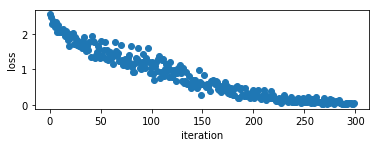

In [12]:
import matplotlib.pyplot as plt
plt.subplot(2, 1, 1)
plt.plot(solver.loss_history, 'o')
plt.xlabel('iteration')
plt.ylabel('loss')

plt.show()